In [1]:
!pwd

/home/airg/rbalogun/ftwfieldmapper


In [2]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

# Load checkpoint
checkpoint = torch.load("model_weights/ftw-3class-full_unet-efficientnetb3_rgbnir_1ba4e1bd.pth")

# Remove _conv_stem.weight
checkpoint.pop("encoder._conv_stem.weight", None)

model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=4,  # 4 channels
    classes=3
)

# Load everything else
missing, unexpected = model.load_state_dict(checkpoint, strict=False)

print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")

# Reinitialize first conv layer manually (if you want better initialization)
with torch.no_grad():
    nn.init.kaiming_normal_(model.encoder._conv_stem.weight, mode='fan_out', nonlinearity='relu')


Missing keys: ['encoder._conv_stem.weight']
Unexpected keys: []


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      4, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [4]:
device

device(type='cuda')

In [5]:
import yaml
import time
import torch

import numpy as np
import pandas as pd 
from torch.utils.data import DataLoader

configPath = "./src/configs/config_lacuna.yaml"

with open(configPath, "r") as config:
        params = yaml.safe_load(config)

# parameters
params_train = params['Train_Validate']
params_test = params['Test']

In [6]:
# load lacuna datasets. 
from src.lacuna.datatorch import ImageData

# Load data
print('Loading training dataset')
            
train_dataset = ImageData(
        data_path = params_train['data_path'],
        log_dir = params_train['log_dir'], 
        catalog = pd.read_csv(params_train['train_csv_name']).reset_index(drop=True), 
        data_size = params_train['data_size'],
        buffer = params_train['buffer'],
        buffer_comp = params_train['buffer_comp'],
        usage = "train", 
        img_path_cols = params_train['img_path_cols'], 
        label_path_col = params_train['label_path_col'], 
        label_group = params_train['label_group'], 
        apply_normalization = params_train['apply_normalization'],
        normal_strategy = params_train['normal_strategy'],
        stat_procedure = params_train['stat_procedure'],
        global_stats = params_train['global_stats'],
        catalog_index = params_train['catalog_index'],
        trans = params_train['trans'],
        parallel = params_train['parallel'],
        scale_factor = params_train['scale_factor'],
        crop_strategy = params_train['crop_strategy'],
        rotation_degree = params_train['rotation_degree'],
        sigma_range = params_train['sigma_range'],
        br_range = params_train['br_range'],
        contrast_range = params_train['contrast_range'],
        bshift_gamma_range = params_train['bshift_gamma_range'],
        patch_shift = params_train['patch_shift'],
        downfactor = params_train['downfactor'],
        clip_val = params_train['clip_val'],
        nodata = params_train['nodata']
        )
    
train_dataloader = DataLoader(
                        train_dataset,
                        batch_size=params_train["train_batch"],
                        shuffle=True
                        )

# Load data
print('Loading validation dataset')

val_dataset = ImageData(
        data_path = params_train['data_path'],
        log_dir = params_train['log_dir'], 
        catalog = pd.read_csv(params_train['train_csv_name']).reset_index(drop=True), 
        data_size = params_train['data_size'],
        buffer = params_train['buffer'],
        buffer_comp = params_train['buffer_comp'],
        usage = "validate", 
        img_path_cols = params_train['img_path_cols'], 
        label_path_col = params_train['label_path_col'], 
        label_group = params_train['label_group'], 
        apply_normalization = params_train['apply_normalization'],
        normal_strategy = params_train['normal_strategy'],
        stat_procedure = params_train['stat_procedure'],
        global_stats = params_train['global_stats'],
        catalog_index = params_train['catalog_index'],
        trans = params_train['trans'],
        parallel = params_train['parallel'],
        scale_factor = params_train['scale_factor'],
        crop_strategy = params_train['crop_strategy'],
        rotation_degree = params_train['rotation_degree'],
        sigma_range = params_train['sigma_range'],
        br_range = params_train['br_range'],
        contrast_range = params_train['contrast_range'],
        bshift_gamma_range = params_train['bshift_gamma_range'],
        patch_shift = params_train['patch_shift'],
        downfactor = params_train['downfactor'],
        clip_val = params_train['clip_val'],
        nodata = params_train['nodata']
        )

val_dataloader = DataLoader(
                        val_dataset,
                        batch_size=params_train["validate_batch"],
                        shuffle=False
                        )

Loading training dataset
type: <class 'numpy.ndarray'> shape/len: (224, 224, 4)
----------20241 samples loaded in train dataset-----------
Total number of samples in train dataset: 20241
Loading validation dataset
type: <class 'numpy.ndarray'> shape/len: (224, 224, 4)
----------6746 samples loaded in validate dataset-----------
Total number of samples in validate dataset: 6746


##### Finetuning ftw model on lacuna datasets

/home/airg/rbalogun/miniconda3/envs/ftw_fieldmapper/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



--- Epoch 1/50 ---


Validating: 100%|███████████████████████| 675/675 [00:34<00:00, 19.61it/s]


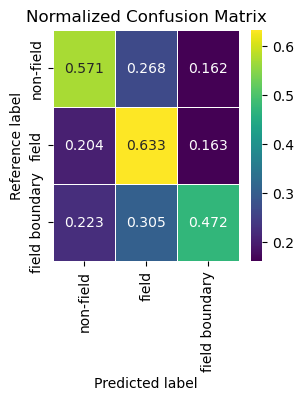

Train Loss: 0.6455 | Val Loss: 0.6986 | OA: 0.5899 | mIoU: 0.3600
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 2/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 35.83it/s]


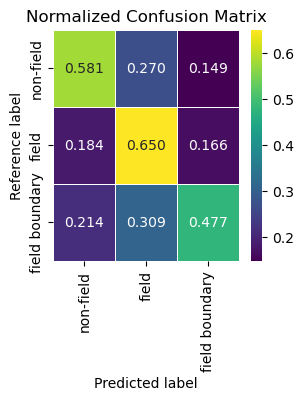

Train Loss: 0.6409 | Val Loss: 0.6908 | OA: 0.6029 | mIoU: 0.3709
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 3/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.68it/s]


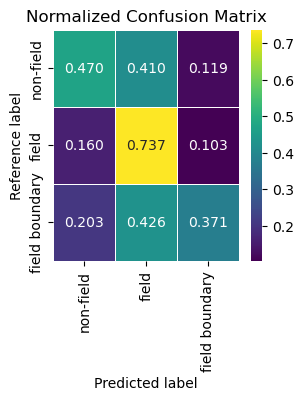

Train Loss: 0.6383 | Val Loss: 0.7158 | OA: 0.5740 | mIoU: 0.3390
  → Early stopping counter: 1/10

--- Epoch 4/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.65it/s]


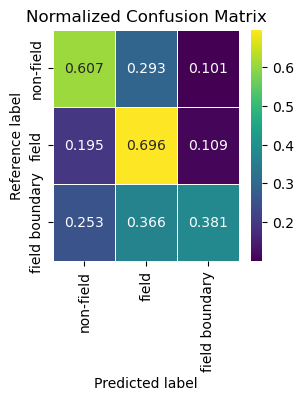

Train Loss: 0.6364 | Val Loss: 0.6947 | OA: 0.6284 | mIoU: 0.3842
  → Early stopping counter: 2/10

--- Epoch 5/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.55it/s]


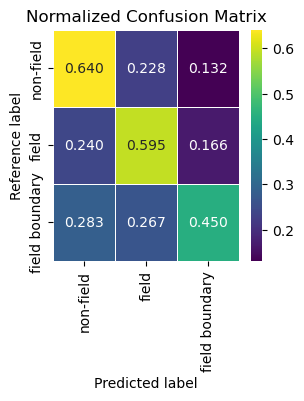

Train Loss: 0.6353 | Val Loss: 0.6956 | OA: 0.6088 | mIoU: 0.3721
  → Early stopping counter: 3/10

--- Epoch 6/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.72it/s]


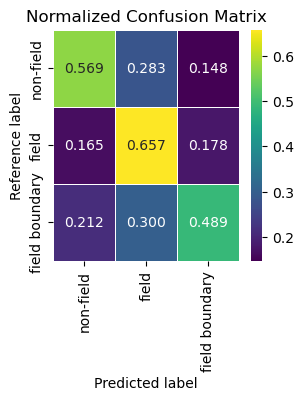

Train Loss: 0.6340 | Val Loss: 0.6897 | OA: 0.6000 | mIoU: 0.3695
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 7/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.49it/s]


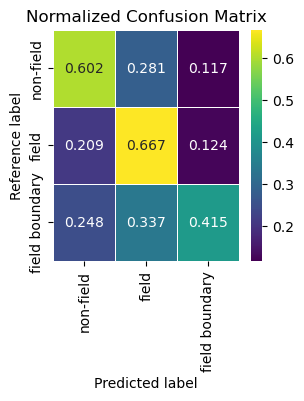

Train Loss: 0.6331 | Val Loss: 0.6920 | OA: 0.6165 | mIoU: 0.3770
  → Early stopping counter: 1/10

--- Epoch 8/50 ---


Validating: 100%|███████████████████████| 675/675 [00:17<00:00, 37.78it/s]


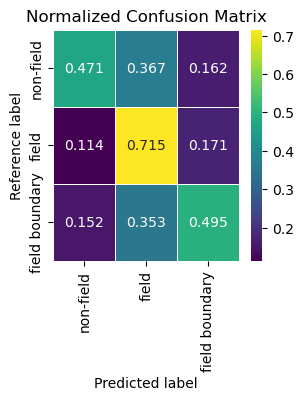

Train Loss: 0.6315 | Val Loss: 0.6952 | OA: 0.5733 | mIoU: 0.3478
  → Early stopping counter: 2/10

--- Epoch 9/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 36.57it/s]


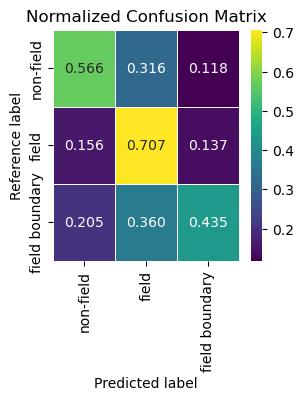

Train Loss: 0.6302 | Val Loss: 0.6874 | OA: 0.6157 | mIoU: 0.3783
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 10/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.14it/s]


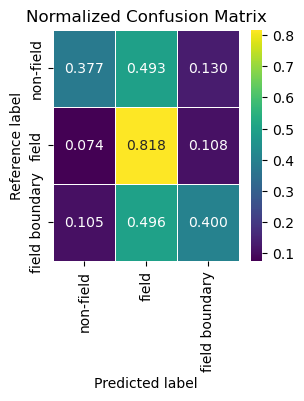

Train Loss: 0.6293 | Val Loss: 0.7110 | OA: 0.5608 | mIoU: 0.3271
  → Early stopping counter: 1/10

--- Epoch 11/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.27it/s]


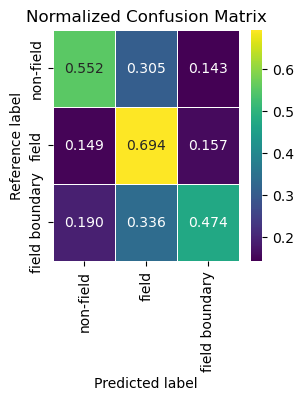

Train Loss: 0.6290 | Val Loss: 0.6879 | OA: 0.6053 | mIoU: 0.3727
  → Early stopping counter: 2/10

--- Epoch 12/50 ---


Validating: 100%|███████████████████████| 675/675 [00:27<00:00, 24.25it/s]


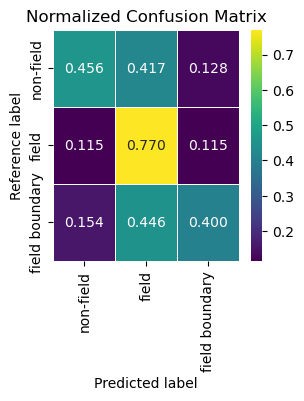

Train Loss: 0.6277 | Val Loss: 0.7066 | OA: 0.5819 | mIoU: 0.3466
  → Early stopping counter: 3/10

--- Epoch 13/50 ---


Validating: 100%|███████████████████████| 675/675 [00:25<00:00, 26.99it/s]


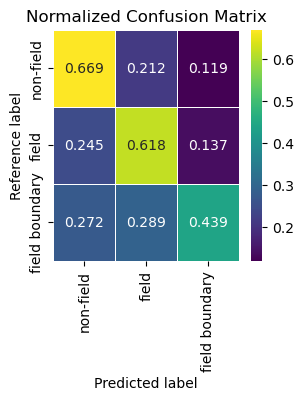

Train Loss: 0.6273 | Val Loss: 0.6839 | OA: 0.6327 | mIoU: 0.3909
  → New best model saved to ./checkpoints/best_model.pth

--- Epoch 14/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 36.92it/s]


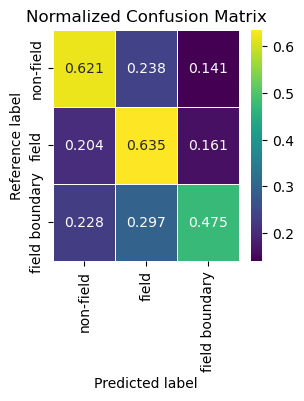

Train Loss: 0.6264 | Val Loss: 0.6855 | OA: 0.6169 | mIoU: 0.3816
  → Early stopping counter: 1/10

--- Epoch 15/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 35.62it/s]


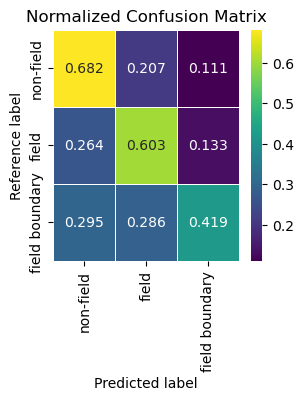

Train Loss: 0.6261 | Val Loss: 0.6890 | OA: 0.6317 | mIoU: 0.3878
  → Early stopping counter: 2/10

--- Epoch 16/50 ---


Validating: 100%|███████████████████████| 675/675 [00:20<00:00, 32.63it/s]


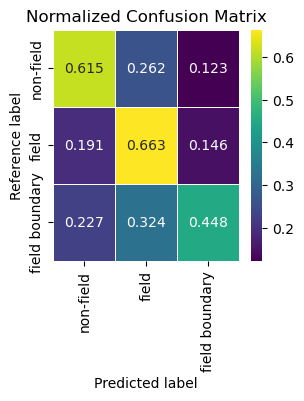

Train Loss: 0.6247 | Val Loss: 0.6844 | OA: 0.6238 | mIoU: 0.3857
  → Early stopping counter: 3/10

--- Epoch 17/50 ---


Validating: 100%|███████████████████████| 675/675 [00:19<00:00, 34.88it/s]


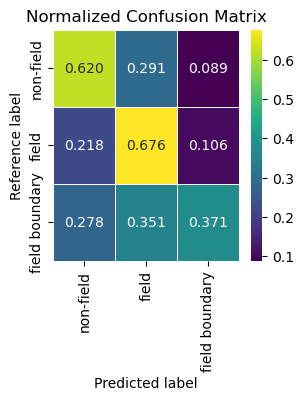

Train Loss: 0.6247 | Val Loss: 0.6958 | OA: 0.6266 | mIoU: 0.3818
  → Early stopping counter: 4/10

--- Epoch 18/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.10it/s]


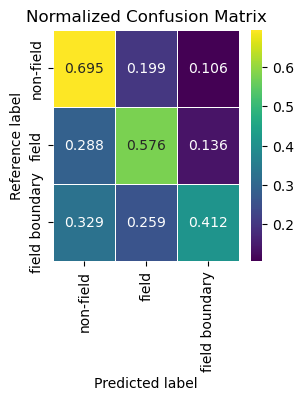

Train Loss: 0.6242 | Val Loss: 0.6941 | OA: 0.6269 | mIoU: 0.3821
  → Early stopping counter: 5/10

--- Epoch 19/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.23it/s]


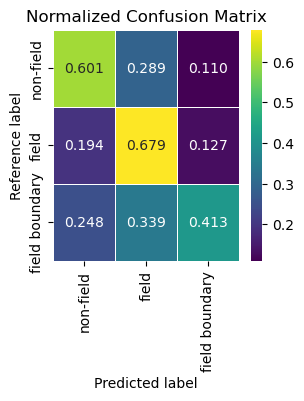

Train Loss: 0.6232 | Val Loss: 0.6909 | OA: 0.6208 | mIoU: 0.3805
  → Early stopping counter: 6/10

--- Epoch 20/50 ---


Validating: 100%|███████████████████████| 675/675 [00:21<00:00, 31.83it/s]


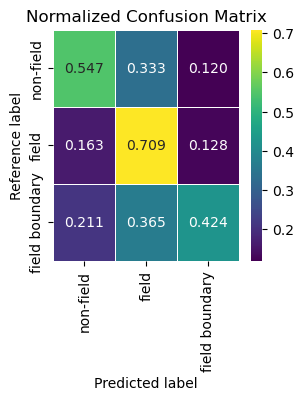

Train Loss: 0.6224 | Val Loss: 0.6922 | OA: 0.6056 | mIoU: 0.3691
  → Early stopping counter: 7/10

--- Epoch 21/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.12it/s]


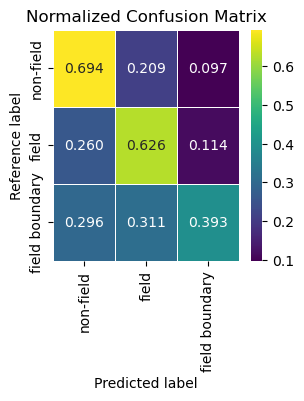

Train Loss: 0.6226 | Val Loss: 0.6879 | OA: 0.6459 | mIoU: 0.3979
  → Early stopping counter: 8/10

--- Epoch 22/50 ---


Validating: 100%|███████████████████████| 675/675 [00:20<00:00, 33.46it/s]


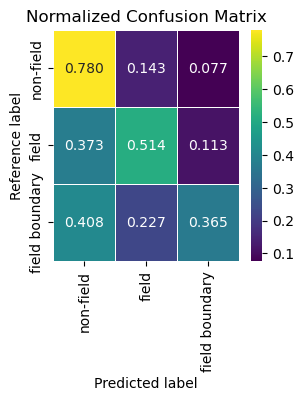

Train Loss: 0.6213 | Val Loss: 0.6975 | OA: 0.6426 | mIoU: 0.3865
  → Early stopping counter: 9/10

--- Epoch 23/50 ---


Validating: 100%|███████████████████████| 675/675 [00:18<00:00, 37.35it/s]


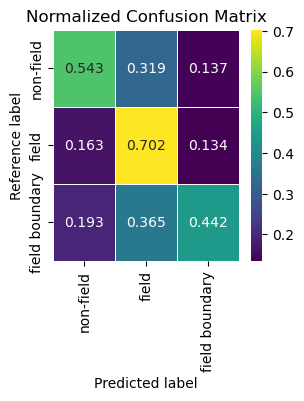

Train Loss: 0.6204 | Val Loss: 0.6941 | OA: 0.6022 | mIoU: 0.3677
  → Early stopping counter: 10/10
Early stopping triggered. Stopping training.

All training metrics saved to ./checkpoints/training_metrics.csv


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
import pandas as pd
import numpy as np


import segmentation_models_pytorch as smp
from src.lacuna.evaluate import evaluate
from src.lacuna.datatorch import ImageData
from src.lacuna.losses import tversky_focal 


# # Define loss (Dice Loss + CrossEntropy Loss)
# class DiceCrossEntropyLoss(nn.Module):
#     def __init__(self, weight_dice=0.5, weight_ce=0.5):
#         super().__init__()
#         self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
#         self.ce_loss = nn.CrossEntropyLoss()
#         self.weight_dice = weight_dice
#         self.weight_ce = weight_ce

#     def forward(self, preds, targets):
#         dice = self.dice_loss(preds, targets)
#         ce = self.ce_loss(preds, targets)
#         return self.weight_dice * dice + self.weight_ce * ce

criterion = tversky_focal.LocallyWeightedTverskyFocalLoss()

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=params_train["learning_rate_init"])
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=10, verbose=True)

# Paths
num_epochs = params_train["epoch"]
early_stopping_patience = params_train.get("early_stopping_patience", 10)
checkpoint_dir = params_train.get("model_out_dir/", "./checkpoints")
metrics_log_file = os.path.join(checkpoint_dir, "training_metrics.csv")
os.makedirs(checkpoint_dir, exist_ok=True)

# Class Mapping for evaluation
class_mapping = params_train["class_mapping"]

# Training
best_val_loss = float("inf")
early_stopping_counter = 0
metrics_records = []

for epoch in range(1, num_epochs + 1):
    print(f"\n--- Epoch {epoch}/{num_epochs} ---")

    model.train()
    train_loss = 0.0

    for imgs, labels, mask in tqdm(train_dataloader, desc="Training"):
        imgs, labels, mask = imgs.to(device), labels.to(device), mask.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_dataloader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader, desc="Validating"):
            # imgs, labels, mask = imgs.to(device), labels.to(device), mask.to(device)
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_dataloader.dataset)
    scheduler.step(val_loss)

    # Evaluate using your Evaluator
    eval_metrics = evaluate(
        model=model,
        dataloader=val_dataloader,
        num_classes=3,
        class_mapping=class_mapping,
        device=device,
        buffer=params_train.get('buffer', None),
        out_name=os.path.join(checkpoint_dir, f"epoch{epoch}_metrics.csv")
    )

    epoch_metrics = {
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "overall_accuracy": eval_metrics["Overall Accuracy"],
        "mean_accuracy": eval_metrics["Mean Accuracy"],
        "mean_iou": eval_metrics["Mean IoU"],
        "mean_precision": eval_metrics["mean Precision"],
        "mean_recall": eval_metrics["mean Recall"],
        "mean_f1_score": eval_metrics["Mean F1 Score"],
    }
    metrics_records.append(epoch_metrics)

    print(
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"OA: {eval_metrics['Overall Accuracy']:.4f} | mIoU: {eval_metrics['Mean IoU']:.4f}"
    )

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"  → New best model saved to {checkpoint_path}")
    else:
        early_stopping_counter += 1
        print(f"  → Early stopping counter: {early_stopping_counter}/{early_stopping_patience}")

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered. Stopping training.")
        break

# Save metrics
metrics_df = pd.DataFrame(metrics_records)
metrics_df.to_csv(metrics_log_file, index=False)
print(f"\nAll training metrics saved to {metrics_log_file}")


#### Inference Pipeline

In [ ]:
checkpoint_path = os.path.join('./checkpoints/', "best_model.pth")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# ------------------------
# Load Test Data
# ------------------------
print("Loading test dataset...")
test_dataset = ImageData(
    data_path=params_train['data_path'],
    log_dir=params_train['log_dir'], 
    catalog=pd.read_csv(params_train['train_csv_name']).reset_index(drop=True),  
    data_size=params_train['data_size'],
    buffer=params_train['buffer'],
    buffer_comp=params_train['buffer_comp'],
    usage="test", 
    img_path_cols=params_train['img_path_cols'], 
    label_path_col=params_train['label_path_col'], 
    label_group=params_train['label_group'], 
    apply_normalization=params_train['apply_normalization'],
    normal_strategy=params_train['normal_strategy'],
    stat_procedure=params_train['stat_procedure'],
    global_stats=params_train['global_stats'],
    catalog_index=params_train['catalog_index'],
    trans=params_train['trans'],
    parallel=params_train['parallel'],
    scale_factor=params_train['scale_factor'],
    crop_strategy=params_train['crop_strategy'],
    rotation_degree=params_train['rotation_degree'],
    sigma_range=params_train['sigma_range'],
    br_range=params_train['br_range'],
    contrast_range=params_train['contrast_range'],
    bshift_gamma_range=params_train['bshift_gamma_range'],
    patch_shift=params_train['patch_shift'],
    downfactor=params_train['downfactor'],
    clip_val=params_train['clip_val'],
    nodata=params_train['nodata']
)

from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    test_dataset,
    batch_size=params_train["validate_batch"],
    shuffle=False
)


# Inference & Evaluation
print("Running inference on test dataset...")
class_mapping = params_train["class_mapping"]

metrics = evaluate(
    model=model,
    dataloader=test_dataloader,
    num_classes=3,
    class_mapping=class_mapping,
    device=device,
    buffer=params_test.get('buffer', None),
    out_name=os.path.join(checkpoint_dir, "test_metrics.csv")
)

# Print and save results
print("\nTest Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

metrics_df = pd.DataFrame([metrics])
os.makedirs(params_test.get("out_dir", "./test_results"), exist_ok=True)
metrics_df.to_csv(os.path.join(checkpoint_dir, "summary_metrics.csv"), index=False)

Loading test dataset...
type: <class 'numpy.ndarray'> shape/len: (224, 224, 4)


#### Visualize Predictions

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, class_mapping, device, num_images=4):
    """
    Visualizes predictions alongside ground truth for a few samples.
    
    Args:
        model (nn.Module): Trained segmentation model.
        dataloader (DataLoader): Validation/test DataLoader.
        class_mapping (dict): Mapping of class indices to names.
        device (torch.device): CPU or CUDA.
        num_images (int): Number of samples to visualize.
    """
    model.eval()
    cmap = plt.get_cmap("tab10")  # for consistent color mapping
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(min(num_images, images.shape[0])):
                img = images[i].cpu().numpy()
                label = labels[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                # If image has 4 channels, use RGB only for visualization
                img_disp = img[:3, :, :] if img.shape[0] >= 3 else img
                img_disp = np.moveaxis(img_disp, 0, -1)  # CxHxW -> HxWxC
                img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(img_disp)
                axes[0].set_title("Input Image")
                axes[0].axis('off')

                axes[1].imshow(label, cmap="tab10", vmin=0, vmax=len(class_mapping)-1)
                axes[1].set_title("Ground Truth")
                axes[1].axis('off')

                axes[2].imshow(pred, cmap="tab10", vmin=0, vmax=len(class_mapping)-1)
                axes[2].set_title("Prediction")
                axes[2].axis('off')

                plt.tight_layout()
                plt.show()

            break  # Only first batch


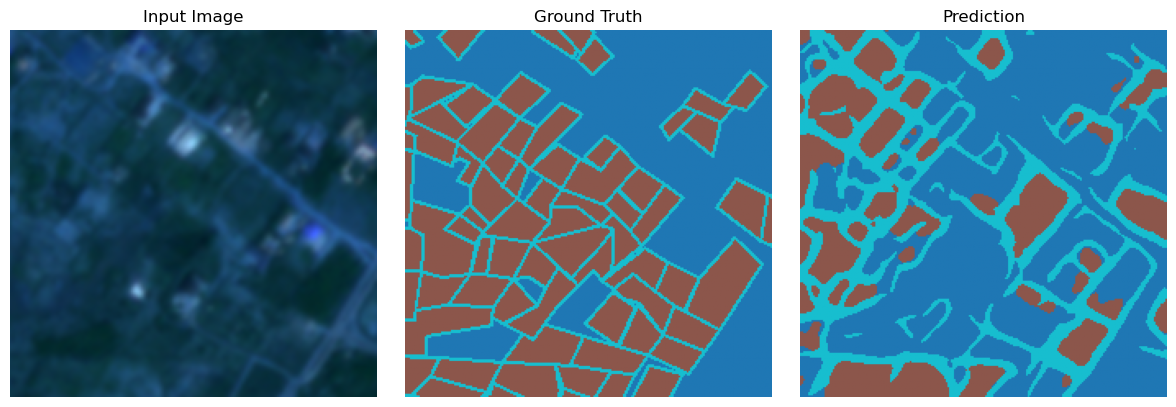

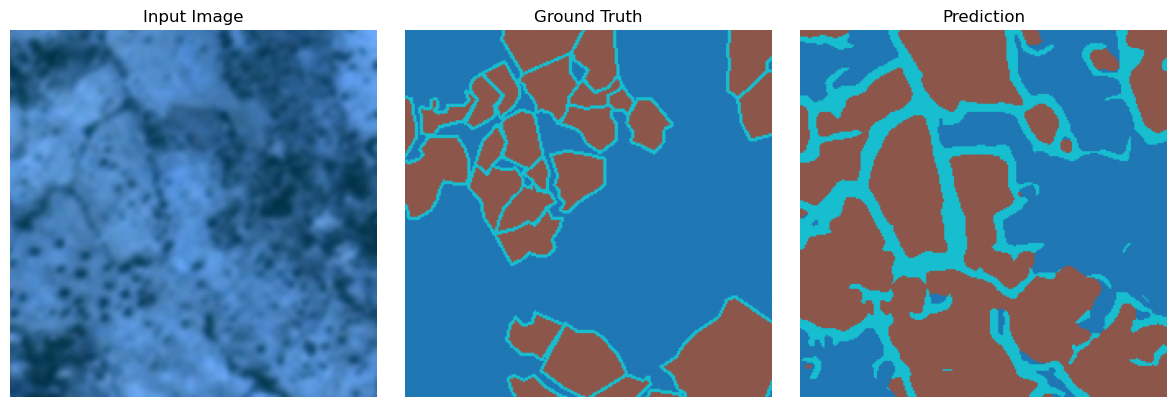

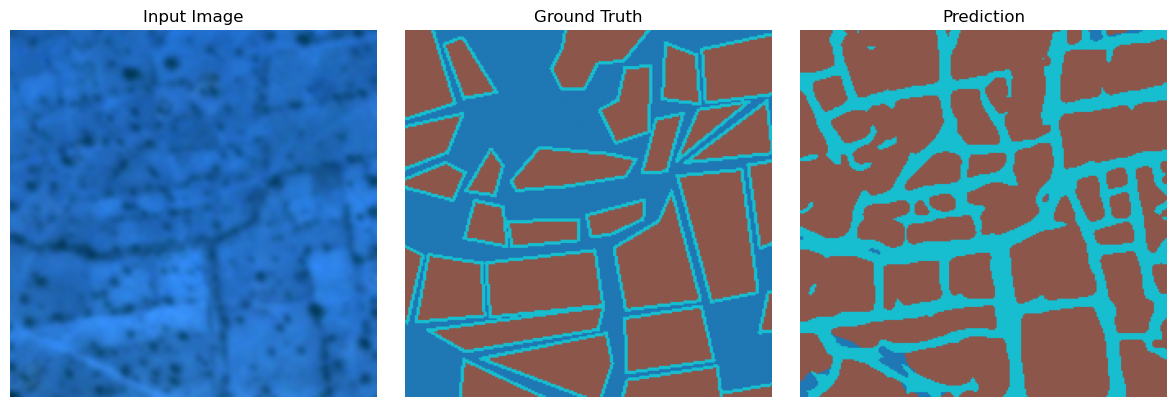

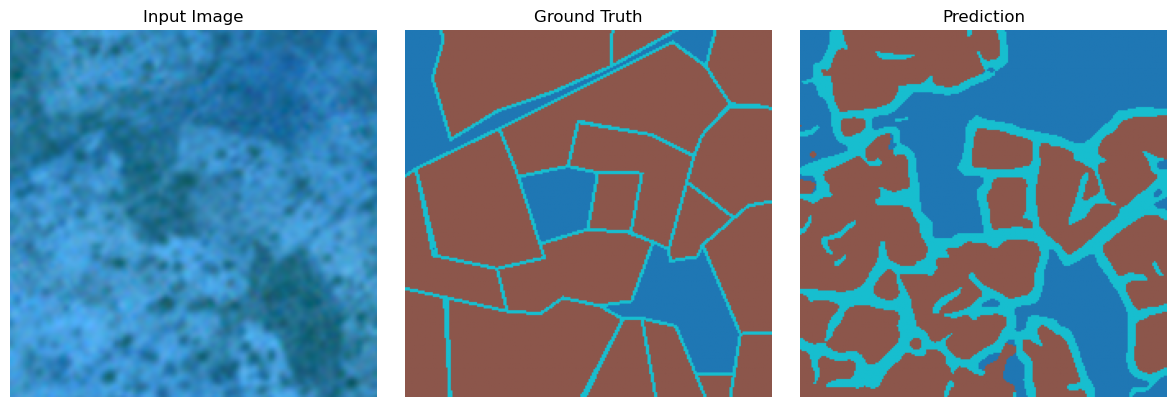

In [16]:
visualize_predictions(
    model=model,
    dataloader=val_dataloader,
    class_mapping=class_mapping,
    device=device,
    num_images=4
)